In [2]:
from datetime import datetime
import pandas_datareader as reader

df = reader.get_data_yahoo(['ETH-USD'], start=datetime(2015,7,30))
df


Attributes    Adj Close        Close         High          Low         Open  \
Symbols         ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD   
Date                                                                          
2015-08-06     2.772120     2.772120     3.536610     2.521120     2.831620   
2015-08-07     0.753325     0.753325     2.798810     0.714725     2.793760   
2015-08-08     0.701897     0.701897     0.879810     0.629191     0.706136   
2015-08-09     0.708448     0.708448     0.729854     0.636546     0.713989   
2015-08-10     1.067860     1.067860     1.131410     0.663235     0.708087   
...                 ...          ...          ...          ...          ...   
2021-11-06  4521.581055  4521.581055  4530.997070  4334.973633  4482.647949   
2021-11-07  4620.554688  4620.554688  4640.921875  4510.984375  4523.981934   
2021-11-08  4812.087402  4812.087402  4822.363281  4619.649414  4619.649414   
2021-11-09  4735.068848  4735.068848  4837.589355  4718.039062  4810.071289   
2021-11-10  4848.248535  4848.248535  4858.822266  4683.004883  4740.288574   

Attributes        Volume  
Symbols          ETH-USD  
Date                      
2015-08-06  1.643290e+05  
2015-08-07  6.741880e+05  
2015-08-08  5.321700e+05  
2015-08-09  4.052830e+05  
2015-08-10  1.463100e+06  
...                  ...  
2021-11-06  1.442908e+10  
2021-11-07  1.354138e+10  
2021-11-08  1.929090e+10  
2021-11-09  2.083417e+10  
2021-11-10  1.769133e+10  

[2284 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 2015-08-06 to 2021-11-10
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Adj Close, ETH-USD)  2284 non-null   float64
 1   (Close, ETH-USD)      2284 non-null   float64
 2   (High, ETH-USD)       2284 non-null   float64
 3   (Low, ETH-USD)        2284 non-null   float64
 4   (Open, ETH-USD)       2284 non-null   float64
 5   (Volume, ETH-USD)     2284 non-null   float64
dtypes: float64(6)
memory usage: 124.9 KB
None


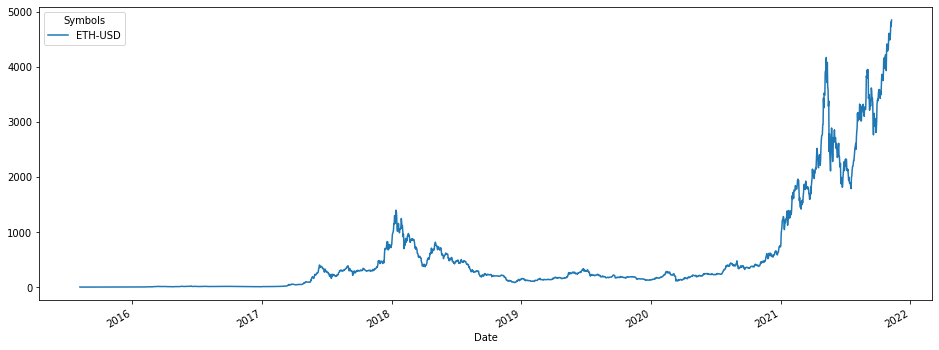

In [3]:
import pandas as pd

pd.plotting.register_matplotlib_converters()

print(df.info())

df['Close'].plot(figsize=(16,6))

In [4]:
df[df.index.duplicated()]

Attributes    Adj Close        Close         High          Low         Open  \
Symbols         ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD   
Date                                                                          
2016-03-27    11.665600    11.665600    11.861300    10.407500    10.431400   
2017-03-26    50.521599    50.521599    51.802898    49.283901    50.769901   
2018-03-25   489.950989   489.950989   526.379028   470.440002   524.286987   
2019-03-31   141.830322   141.830322   142.733994   140.737564   141.465485   
2020-03-29   132.904541   132.904541   133.911469   125.289680   125.577896   
2021-03-28  1691.355957  1691.355957  1728.584106  1672.660400  1716.405640   

Attributes        Volume  
Symbols          ETH-USD  
Date                      
2016-03-27  2.318830e+07  
2017-03-26  1.068590e+08  
2018-03-25  1.638880e+09  
2019-03-31  4.612000e+09  
2020-03-29  1.184112e+10  
2021-03-28  1.659947e+10

In [5]:
df = df[~df.index.duplicated(keep='first')]
df = df['Close']

In [6]:
from azureml.core import Workspace, Dataset

ws = Workspace.from_config()
datastore = ws.get_default_datastore()

df_sans_last_60_days = df[:-60]
df_sans_last_60_days.reset_index(inplace=True)
training_data = Dataset.Tabular.register_pandas_dataframe(
    df_sans_last_60_days, datastore, 'EthereumRates')

Method register_pandas_dataframe: This is an experimental method, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/azureml/data/dataset_factory.py:1216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column])


Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/cfdfb5ee-6e14-465e-a361-15cbe49bdfb9/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [7]:
from azureml.core.compute import ComputeTarget, AmlCompute

compute_name = 'shrek'

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print(f'Using existing compute: {compute_name}')    
else:
    print(f'Creating new compute: {compute_name}')
    provisioning_config = AmlCompute.provisioning_configuration(
        vm_size = 'Standard_F4s_v2',
        min_nodes = 0, 
        max_nodes = 4)

    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    compute_target.wait_for_completion(show_output=True)

Creating new compute: shrek
InProgress....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [8]:
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.forecasting_parameters import ForecastingParameters

forecasting_parameters = ForecastingParameters(
    time_column_name='Date',
    freq='1D',
    forecast_horizon=1,
    feature_lags='auto',
    target_lags=[7],
    use_stl=None,
    country_or_region_for_holidays='US',
)

In [9]:
automl_config = AutoMLConfig(
    task = "forecasting",
    primary_metric='normalized_root_mean_squared_error',

    training_data = training_data,
    label_column_name = 'ETH-USD',
    n_cross_validations=7,

    enable_early_stopping=True,
    early_stopping_n_iters=20,
    max_concurrent_iterations=4,
    iteration_timeout_minutes=5,

    compute_target=compute_target,
    forecasting_parameters=forecasting_parameters
)

In [10]:
from azureml.core import Experiment
from azureml.core import Workspace, Dataset

ws = Workspace.from_config()
experiment = Experiment(ws, "AutoML-Forecasting")
run = experiment.submit(automl_config, show_output=True)


best_run, best_model = run.get_output()

Submitting remote run.
No run_configuration provided, running on shrek with default configuration
Running on remote compute: shrek


In [2]:
from azureml.core import Experiment
from azureml.train.automl.run import AutoMLRun
from azureml.core import Workspace, Dataset
from azureml.automl.core.forecasting_parameters import ForecastingParameters

ws = Workspace.from_config()
datastore = ws.get_default_datastore()

experiment = Experiment(ws, "ETH_reg")
runs = list(experiment.get_runs()) 

run = AutoMLRun(experiment, runs[0].id)
best_run, best_model = run.get_output()

ModuleNotFoundError: No module named 'azureml.train'

In [17]:
from datetime import datetime
import pandas as pd
range = pd.date_range(datetime(2021,9,11), datetime(2021,11,11))

forecast_df = pd.DataFrame({ 'Date': range })

In [18]:
forecast, transformed_df = best_model.forecast(forecast_df)

AttributeError: 'RegressionPipeline' object has no attribute 'forecast'

In [19]:
pretty_df = forecast_df.copy().set_index('Date')
pretty_df['ETH-USD-forecast'] = forecast
pretty_df['ETH-USD'] = df['ETH-USD']

pretty_df[['ETH-USD', 'ETH-USD-forecast']].plot(figsize=(16,6))

NameError: name 'forecast' is not defined